<a href="https://colab.research.google.com/github/Ajinkya-18/NeuroVision/blob/main/neurovision3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from datasets import load_dataset
ds = load_dataset("Alljoined/05_125")

In [ ]:
# import os
# import requests
# import zipfile
# from tqdm.auto import tqdm

# # --- Configuration ---
# # The URL for the COCO 2017 training images
# COCO_IMAGES_URL = "http://images.cocodataset.org/zips/train2017.zip"
# # Where to save the downloaded zip file
# ZIP_SAVE_PATH = "/content/train2017.zip"
# # Where to extract the images
# EXTRACT_DIR = "/content/coco_images"

# # --- Download the dataset ---
# print(f"Downloading COCO 2017 training images from {COCO_IMAGES_URL}...")
# response = requests.get(COCO_IMAGES_URL, stream=True)

# # Check if the request was successful
# if response.status_code == 200:
#     total_size = int(response.headers.get('content-length', 0))
#     with open(ZIP_SAVE_PATH, 'wb') as f, tqdm(
#         desc="Downloading",
#         total=total_size,
#         unit='iB',
#         unit_scale=True,
#         unit_divisor=1024,
#     ) as bar:
#         for data in response.iter_content(chunk_size=1024):
#             f.write(data)
#             bar.update(len(data))
#     print("Download complete.")

#     # --- Unzip the dataset ---
#     print(f"Extracting images to {EXTRACT_DIR}...")
#     with zipfile.ZipFile(ZIP_SAVE_PATH, 'r') as zip_ref:
#         zip_ref.extractall(EXTRACT_DIR)
#     print("Extraction complete.")

#     # --- Clean up the zip file ---
#     os.remove(ZIP_SAVE_PATH)
#     print("Cleaned up the zip file.")
#     print(f"Your COCO images are now ready in: {EXTRACT_DIR}/train2017")
# else:
#     print(f"Error: Failed to download the dataset. Status code: {response.status_code}")

In [ ]:
# --- Run this cell to free up disk space ---
# !rm -rf /content/alljoined_final_224
# print("Cleaned up the incomplete dataset directory.")

In [ ]:
# import os
# import torch
# import numpy as np
# from pathlib import Path
# from tqdm.auto import tqdm
# from scipy.signal import butter, sosfiltfilt, spectrogram
# from datasets import load_dataset
# from PIL import Image
# from torchvision.transforms import v2 as transforms

# # ==============================================================================
# # --- 1. CONFIGURATION for All-in-One Preprocessing ---
# # ==============================================================================
# class CONFIG_ALL_IN_ONE:
#     # --- Source Data Paths ---
#     COCO_IMAGE_DIR = "/content/coco_images/train2017"
#     HUGGINGFACE_DATASET = "Alljoined/05_125"

#     # --- Final Processed Data Paths ---
#     OUTPUT_DATA_ROOT = '/content/alljoined_final_224_split' # <-- New root directory
#     OUTPUT_TRAIN_DIR = os.path.join(OUTPUT_DATA_ROOT, 'train')
#     OUTPUT_TEST_DIR = os.path.join(OUTPUT_DATA_ROOT, 'test')

#     # --- NEW: Define train and test sample sizes ---
#     TRAIN_SAMPLES = 14000
#     TEST_SAMPLES = 200

#     # --- Signal Processing Hyperparameters ---
#     FS = 250
#     LOW_CUT = 4
#     HIGH_CUT = 100
#     FILTER_ORDER = 5
#     MIN_SIGNAL_LENGTH = 250

#     # --- STFT Spectrogram Hyperparameters ---
#     NPERSEG = 128
#     NOVERLAP = 64

#     # --- Final Image/Spectrogram Size ---
#     FINAL_SIZE = 224
#     EEG_CHANNELS = 64

# # ==============================================================================
# # --- 2. Preprocessing Functions (Unchanged) ---
# # ==============================================================================
# def bandpass_filter(data, lowcut, highcut, fs, order=5):
#     nyq = 0.5 * fs
#     low = lowcut / nyq
#     high = highcut / nyq
#     sos = butter(order, [low, high], analog=False, btype='band', output='sos')
#     return sosfiltfilt(sos, data, axis=1)

# def generate_stft_spectrogram(eeg_data, config):
#     filtered_eeg = bandpass_filter(eeg_data, config.LOW_CUT, config.HIGH_CUT, config.FS, config.FILTER_ORDER)
#     channel_spectrograms = []
#     for i in range(filtered_eeg.shape[0]):
#         _, _, Sxx = spectrogram(filtered_eeg[i, :], fs=config.FS, nperseg=config.NPERSEG, noverlap=config.NOVERLAP)
#         spec = np.log1p(Sxx)
#         channel_spectrograms.append(spec)
#     return torch.tensor(np.array(channel_spectrograms), dtype=torch.float32)

# # ==============================================================================
# # --- 3. Main All-in-One Preparation Script ---
# # ==============================================================================
# def prepare_final_dataset(config):
#     print("--- Starting All-in-One dataset preparation with Train/Test split ---")
#     train_dir = Path(config.OUTPUT_TRAIN_DIR)
#     test_dir = Path(config.OUTPUT_TEST_DIR)
#     train_dir.mkdir(parents=True, exist_ok=True)
#     test_dir.mkdir(parents=True, exist_ok=True)

#     print(f"Loading {config.HUGGINGFACE_DATASET}...")
#     ds = load_dataset(config.HUGGINGFACE_DATASET, split='train', streaming=True)
#     print("Dataset loaded.")

#     eeg_resize = transforms.Resize((config.FINAL_SIZE, config.FINAL_SIZE), antialias=True)
#     image_resize = transforms.Resize((config.FINAL_SIZE, config.FINAL_SIZE))
#     image_to_tensor = transforms.ToTensor()

#     total_samples_to_process = config.TRAIN_SAMPLES + config.TEST_SAMPLES
#     print(f"Processing, resizing, and saving {total_samples_to_process} total tensors...")

#     processed_count = 0
#     saved_count = 0
#     # We iterate through the raw dataset until we have saved enough samples
#     for sample in tqdm(ds, desc="Processing samples"):
#         if saved_count >= total_samples_to_process:
#             break

#         try:
#             eeg_data = np.array(sample['EEG'], dtype=np.float32)
#             if eeg_data.shape != (config.EEG_CHANNELS, 334) or eeg_data.shape[1] < config.MIN_SIGNAL_LENGTH:
#                 continue

#             coco_id = sample['coco_id']
#             image_filename = f"{coco_id:012d}.jpg"
#             image_path = Path(config.COCO_IMAGE_DIR) / image_filename

#             if not image_path.exists():
#                 continue

#             spectrogram_tensor = generate_stft_spectrogram(eeg_data, config)
#             resized_spectrogram = eeg_resize(spectrogram_tensor)

#             image = Image.open(image_path).convert("RGB")
#             resized_image_pil = image_resize(image)
#             resized_image_tensor = image_to_tensor(resized_image_pil)

#             # --- Determine save directory based on count ---
#             if saved_count < config.TRAIN_SAMPLES:
#                 current_save_dir = train_dir
#             else:
#                 current_save_dir = test_dir

#             save_path = current_save_dir / f"sample_{processed_count}.pt"
#             torch.save({
#                 'spectrogram_tensor': resized_spectrogram,
#                 'image_tensor': resized_image_tensor
#             }, save_path)

#             saved_count += 1
#         except Exception as e:
#             pass # Suppress errors for skipped files

#         processed_count += 1


#     print(f"\nSuccessfully processed and saved {saved_count} samples.")

#     # --- Calculate Mean and Std from the TRAINING SET ONLY ---
#     # print("\nCalculating Mean and Std from the training set...")
#     # train_files = list(train_dir.glob('sample_*.pt'))
#     # count = 0
#     # mean = torch.zeros(config.EEG_CHANNELS)
#     # m2 = torch.zeros(config.EEG_CHANNELS)

#     # for path in tqdm(train_files, desc="Calculating Stats"):
#     #     data = torch.load(path)['spectrogram_tensor']
#     #     flat_data = data.view(config.EEG_CHANNELS, -1)
#     #     for i in range(flat_data.size(1)):
#     #         count += 1
#     #         delta = flat_data[:, i] - mean
#     #         mean += delta / count
#     #         delta2 = flat_data[:, i] - mean
#     #         m2 += delta * delta2

#     # std = torch.sqrt(m2 / (count - 1))
#     # # Save stats to the root directory for easy access
#     # torch.save(mean, Path(config.OUTPUT_DATA_ROOT) / 'mean.pt')
#     # torch.save(std, Path(config.OUTPUT_DATA_ROOT) / 'std.pt')
#     # print("Saved new Mean/Std. All preprocessing is complete.")

# # ==============================================================================
# # --- 4. EXECUTION ---
# # ==============================================================================
# if __name__ == '__main__':
#     final_config = CONFIG_ALL_IN_ONE()
#     prepare_final_dataset(final_config)

In [ ]:
# import torch
# from pathlib import Path
# from tqdm.auto import tqdm
# from torch.utils.data import Dataset, DataLoader
# from torchvision.transforms import v2 as transforms

# # ==============================================================================
# # --- 1. CONFIGURATION for Fast Stat Calculation ---
# # ==============================================================================
# class CONFIG_STATS:
#     # --- Source Data Path ---
#     # This is the training set from our final preprocessed data
#     DATA_ROOT = '/content/alljoined_final_224_split/train'

#     # --- Where to save the final stat files ---
#     SAVE_DIR = '/content/alljoined_final_224_split'

#     # --- Parameters ---
#     BATCH_SIZE = 32 # Use a large batch size for efficiency
#     EEG_CHANNELS = 64

# # ==============================================================================
# # --- 2. A Simple Dataset for Loading Tensors ---
# # ==============================================================================
# class StatDataset(Dataset):
#     def __init__(self, root_dir):
#         # The samples are simply all the .pt files in the directory
#         self.samples = list(Path(root_dir).glob('sample_*.pt'))

#     def __len__(self):
#         return len(self.samples)

#     def __getitem__(self, idx):
#         # We only need the spectrogram tensor for this calculation
#         return torch.load(self.samples[idx])['spectrogram_tensor']

# # ==============================================================================
# # --- 3. Optimized Calculation Script ---
# # ==============================================================================
# def calculate_stats_fast(config):
#     print("--- Starting fast mean and standard deviation calculation ---")

#     # --- Setup DataLoader ---
#     dataset = StatDataset(config.DATA_ROOT)
#     # Using multiple workers to speed up file loading
#     loader = DataLoader(dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=2)

#     # --- Initialize variables for calculation ---
#     # We will calculate the sum and sum of squares to derive mean and std
#     n_samples = 0
#     sum_x = torch.zeros(config.EEG_CHANNELS, dtype=torch.float32)
#     sum_x_sq = torch.zeros(config.EEG_CHANNELS, dtype=torch.float32)

#     # --- Iterate over batches (this is much faster) ---
#     for batch in tqdm(loader, desc="Calculating Stats"):
#         # batch shape: (batch_size, channels, height, width)

#         # Sum across all dimensions except for the channel dimension
#         sum_x += batch.sum(dim=[0, 2, 3])
#         sum_x_sq += (batch ** 2).sum(dim=[0, 2, 3])

#         # Keep track of the total number of pixels per channel
#         n_samples += batch.shape[0] * batch.shape[2] * batch.shape[3]

#     # --- Calculate Mean and Std ---
#     mean = sum_x / n_samples
#     std = torch.sqrt((sum_x_sq / n_samples) - (mean ** 2))

#     print("\n--- Calculation Complete ---")
#     print(f"Calculated Mean:\n{mean}")
#     print(f"Calculated Std Dev:\n{std}")

#     # --- Save the results ---
#     save_dir = Path(config.SAVE_DIR)
#     torch.save(mean, save_dir / 'mean.pt')
#     torch.save(std, save_dir / 'std.pt')
#     print(f"\nSaved mean.pt and std.pt to: {config.SAVE_DIR}")

# # ==============================================================================
# # --- 4. EXECUTION ---
# # ==============================================================================
# if __name__ == '__main__':
#     stats_config = CONFIG_STATS()
#     calculate_stats_fast(stats_config)

In [ ]:
import gc
import torch

del ds
gc.collect()
torch.cuda.empty_cache()

In [ ]:
import os
import torch
import timm
from pathlib import Path
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as transforms
from PIL import Image
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

# ==============================================================================
# --- 1. CONFIGURATION for Contrastive Learning on Alljoined1 ---
# ==============================================================================
class CONFIG_CONTRASTIVE_ALLJOINED:
    # --- Source Data Path ---
    PROCESSED_DATA_ROOT = '/content/alljoined_final_224_split'

    # --- Path to your last saved model to resume training ---
    # <-- UPDATE THIS PATH to your '...best.pth' file. Set to None if starting from scratch.
    RESUME_EEG_ENCODER_PATH = '/content/drive/MyDrive/NeuroVision/contrastive_outputs_alljoined/run_20250913_170525/contrastive_eeg_encoder_best.pth'

    # --- Output Paths ---
    OUTPUT_DIR = '/content/drive/MyDrive/NeuroVision/contrastive_outputs_alljoined'

    # --- Hyperparameters ---
    LR = 3e-5
    WEIGHT_DECAY = 0.02
    BATCH_SIZE = 24
    NUM_EPOCHS = 100

    # --- Model Dimensions ---
    EEG_CHANNELS = 64
    ENCODER_DIM = 192
    PROJECTION_DIM = 256

# ==============================================================================
# --- 2. MODEL DEFINITIONS (Unchanged) ---
# ==============================================================================
class ProjectionHead(nn.Module):
    def __init__(self, embedding_dim, projection_dim):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(0.1)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = nn.Parameter(torch.tensor(temperature))

    def forward(self, eeg_embeddings, image_embeddings):
        eeg_embeddings = F.normalize(eeg_embeddings, p=2, dim=1)
        image_embeddings = F.normalize(image_embeddings, p=2, dim=1)
        logits = (eeg_embeddings @ image_embeddings.T) / self.temperature
        labels = torch.arange(len(logits)).to(logits.device)
        loss_eeg = F.cross_entropy(logits, labels)
        loss_image = F.cross_entropy(logits.T, labels)
        return (loss_eeg + loss_image) / 2

# ==============================================================================
# --- 3. DATASET CLASS for Optimized Data ---
# ==============================================================================
class AlljoinedCachedDataset(Dataset):
    def __init__(self, cached_root_dir, eeg_transform, image_transform):
        self.eeg_transform = eeg_transform
        self.image_transform = image_transform
        self.samples = list(Path(cached_root_dir).glob('sample_*.pt'))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        data = torch.load(self.samples[idx])
        spectrogram_tensor = data['spectrogram_tensor']
        image_tensor = data['image_tensor']

        spectrogram_tensor = self.eeg_transform(spectrogram_tensor)
        image_tensor = self.image_transform(image_tensor)

        return spectrogram_tensor, image_tensor

# ==============================================================================
# --- 4. MAIN TRAINING SCRIPT (UPDATED) ---
# ==============================================================================
def run_contrastive_training_alljoined(config):
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    output_dir = os.path.join(config.OUTPUT_DIR, f'run_{timestamp}')
    model_path = os.path.join(output_dir, f'contrastive_eeg_encoder_best.pth')
    os.makedirs(output_dir, exist_ok=True)
    writer = SummaryWriter(os.path.join(output_dir, 'logs'))

    # --- Prepare Data ---
    print("1. Preparing data and DataLoaders...")
    mean = torch.load(Path(config.PROCESSED_DATA_ROOT) / 'mean.pt')
    std = torch.load(Path(config.PROCESSED_DATA_ROOT) / 'std.pt')

    eeg_transform = transforms.Compose([
        transforms.ToDtype(torch.float32, scale=False),
        transforms.Normalize(mean=mean.tolist(), std=std.tolist())
    ])
    image_transform = transforms.Compose([
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_data_dir = os.path.join(config.PROCESSED_DATA_ROOT, 'train')
    dataset = AlljoinedCachedDataset(train_data_dir, eeg_transform, image_transform)

    loader = DataLoader(
        dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        num_workers=2,
        drop_last=True,
        persistent_workers=True
    )

    # --- Initialize Models ---
    print("2. Initializing models...")
    eeg_encoder = timm.create_model(
        'vit_tiny_patch16_224',
        pretrained=True,
        in_chans=config.EEG_CHANNELS,
        num_classes=0
    )

    # --- NEW: Logic to load weights if a checkpoint is provided ---
    if config.RESUME_EEG_ENCODER_PATH and os.path.exists(config.RESUME_EEG_ENCODER_PATH):
        print(f"Resuming training by loading weights from: {config.RESUME_EEG_ENCODER_PATH}")
        eeg_encoder.load_state_dict(torch.load(config.RESUME_EEG_ENCODER_PATH, map_location='cpu'))
    else:
        print("Starting training from scratch (or ImageNet pre-trained weights).")

    eeg_encoder.to(device)

    image_encoder = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=0)
    image_encoder.to(device)

    eeg_projection = ProjectionHead(config.ENCODER_DIM, config.PROJECTION_DIM).to(device)
    image_projection = ProjectionHead(config.ENCODER_DIM, config.PROJECTION_DIM).to(device)

    # --- Training Setup ---
    criterion = ContrastiveLoss().to(device)
    all_params = list(eeg_encoder.parameters()) + list(image_encoder.parameters()) + \
                 list(eeg_projection.parameters()) + list(image_projection.parameters())
    optimizer = optim.AdamW(all_params, lr=config.LR, weight_decay=config.WEIGHT_DECAY)

    best_loss = float('inf')

    # --- Training Loop ---
    print("\n--- Starting Contrastive Learning on Alljoined1 ---")
    for epoch in range(config.NUM_EPOCHS):
        eeg_encoder.train(); image_encoder.train(); eeg_projection.train(); image_projection.train()
        total_loss = 0.0

        progress_bar = tqdm(loader, desc=f"Epoch {epoch+1}/{config.NUM_EPOCHS}")
        for spectrogram_tensors, image_tensors in progress_bar:
            spectrogram_tensors, image_tensors = spectrogram_tensors.to(device), image_tensors.to(device)
            optimizer.zero_grad()

            eeg_features = eeg_encoder.forward_features(spectrogram_tensors)[:, 0]
            image_features = image_encoder.forward_features(image_tensors)[:, 0]

            eeg_embeddings = eeg_projection(eeg_features)
            image_embeddings = image_projection(image_features)

            loss = criterion(eeg_embeddings, image_embeddings)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            progress_bar.set_postfix(Loss=f"{loss.item():.4f}")

        avg_loss = total_loss / len(loader)
        writer.add_scalar('Loss/train', avg_loss, epoch)
        print(f"Epoch {epoch+1}: Average Loss: {avg_loss:.4f}")

        if avg_loss < best_loss:
            best_loss = avg_loss
            print(f"New best loss ({best_loss:.4f}). Saving EEG encoder to {model_path}")
            torch.save(eeg_encoder.state_dict(), model_path)

    writer.close()
    print(f"--- Training complete. Best model saved to {model_path} ---")

# ==============================================================================
# --- 5. EXECUTION ---
# ==============================================================================
if __name__ == '__main__':
    cl_alljoined_config = CONFIG_CONTRASTIVE_ALLJOINED()
    run_contrastive_training_alljoined(cl_alljoined_config)

In [ ]:
import torch
import timm
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as transforms
import os

# ==============================================================================
# --- 1. CONFIGURATION for Final t-SNE Analysis ---
# ==============================================================================
class CONFIG_TSNE_FINAL:
    # --- UPDATE THIS PATH ---
    # Point this to the '.pth' file saved by your successful contrastive training run
    CONTRASTIVE_ENCODER_PATH = '/content/drive/MyDrive/NeuroVision/contrastive_outputs_alljoined/run_20250913_201905/contrastive_eeg_encoder_best.pth'

    # --- Source Data Path ---
    PROCESSED_DATA_ROOT = '/content/alljoined_final_224_split'

    # --- Parameters ---
    BATCH_SIZE = 64
    # We can use all available test samples for a comprehensive plot
    NUM_SAMPLES_TO_PLOT = 1000 # Using the full test set

# ==============================================================================
# --- 2. DATASET CLASS ---
# ==============================================================================
class AlljoinedCachedTSNEDataset(Dataset):
    def __init__(self, cached_root_dir, eeg_transform, max_samples=None):
        self.eeg_transform = eeg_transform
        self.samples = list(Path(cached_root_dir).glob('sample_*.pt'))
        if max_samples:
            self.samples = self.samples[:max_samples]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # We only need the spectrogram for feature extraction
        data = torch.load(self.samples[idx])
        spectrogram_tensor = data['spectrogram_tensor']
        spectrogram_tensor = self.eeg_transform(spectrogram_tensor)

        # We don't have explicit labels, so we'll use the file index as a placeholder
        # The plot will show the raw feature space structure
        return spectrogram_tensor, idx

# ==============================================================================
# --- 3. ANALYSIS SCRIPT ---
# ==============================================================================
def analyze_final_features(config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # --- Load Encoder ---
    print("Loading final contrastive-trained EEG encoder...")
    encoder = timm.create_model(
        'vit_tiny_patch16_224',
        pretrained=True, # Pretrained flag is for architecture, weights will be overwritten
        in_chans=64,
        num_classes=0
    )
    state_dict = torch.load(config.CONTRASTIVE_ENCODER_PATH, map_location='cpu')
    encoder.load_state_dict(state_dict)
    encoder.to(device)
    encoder.eval()
    print("Encoder loaded successfully.")

    # --- Prepare Dataset ---
    print("Preparing test dataset...")
    mean = torch.load(Path(config.PROCESSED_DATA_ROOT) / 'mean.pt')
    std = torch.load(Path(config.PROCESSED_DATA_ROOT) / 'std.pt')

    eeg_transform = transforms.Compose([
        transforms.ToDtype(torch.float32, scale=False),
        transforms.Normalize(mean=mean.tolist(), std=std.tolist())
    ])

    test_data_dir = os.path.join(config.PROCESSED_DATA_ROOT, 'test')
    dataset = AlljoinedCachedTSNEDataset(test_data_dir, eeg_transform, config.NUM_SAMPLES_TO_PLOT)
    loader = DataLoader(dataset, batch_size=config.BATCH_SIZE, shuffle=False)

    # --- Extract Features ---
    print("Extracting features from the test set...")
    all_features = []
    with torch.no_grad():
        for spectrograms, _ in tqdm(loader, desc="Extracting Features"):
            spectrograms = spectrograms.to(device)
            features = encoder.forward_features(spectrograms)[:, 0]
            all_features.append(features.cpu().numpy())

    all_features = np.concatenate(all_features)
    print(f"Extracted {all_features.shape[0]} feature vectors.")

    # --- Run t-SNE ---
    print("Running t-SNE... (This may take a few minutes)")
    tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=500, learning_rate='auto', init='pca')
    tsne_results = tsne.fit_transform(all_features)
    print("t-SNE complete.")

    # --- Plot Results ---
    print("Generating plot...")
    plt.figure(figsize=(12, 8))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5)
    plt.title("t-SNE Visualization of Final EEG Features (Alljoined1 Dataset)")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

# ==============================================================================
# --- 4. EXECUTION ---
# ==============================================================================
if __name__ == '__main__':
    final_tsne_config = CONFIG_TSNE_FINAL()
    analyze_final_features(final_tsne_config)

## Dump

In [ ]:
import os
import torch
import timm
from pathlib import Path
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as transforms
from PIL import Image
import random
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
import accelerate
from datetime import datetime
from torchvision.utils import make_grid

# ==============================================================================
# --- 1. CONFIGURATION for Guided Diffusion ---
# ==============================================================================
class CONFIG_DIFFUSION:
    # --- UPDATE THIS PATH ---
    CONTRASTIVE_ENCODER_PATH = '/content/drive/MyDrive/NeuroVision/contrastive_outputs_alljoined/run_20250913_201905/contrastive_eeg_encoder_best.pth'

    # --- Path to resume from. Set to None to start a new run ---
    RESUME_CHECKPOINT_PATH = '/content/drive/MyDrive/NeuroVision/diffusion_reconstructions_alljoined/run_20250914_122022/model/best_model.pth'

    # --- Source Data Path ---
    PROCESSED_DATA_ROOT = '/content/alljoined_final_224_split'

    # --- Output Paths ---
    OUTPUT_DIR = '/content/drive/MyDrive/NeuroVision/diffusion_reconstructions_alljoined'

    # --- Hyperparameters ---
    LR = 1e-4
    BATCH_SIZE = 16
    NUM_EPOCHS = 100

    # --- Model Dimensions ---
    EEG_CHANNELS = 64
    ENCODER_DIM = 192

    # --- Diffusion Model Settings ---
    MODEL_ID = "CompVis/stable-diffusion-v1-4"
    UNET_CROSS_ATTENTION_DIM = 768
    NUM_INFERENCE_STEPS = 50
    IMG_SIZE = 224

# ==============================================================================
# --- 2. DATASET CLASS ---
# ==============================================================================
class AlljoinedCachedDataset(Dataset):
    def __init__(self, cached_root_dir, eeg_transform, image_transform):
        self.eeg_transform = eeg_transform
        self.image_transform = image_transform
        self.samples = list(Path(cached_root_dir).glob('sample_*.pt'))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        data = torch.load(self.samples[idx])
        spectrogram_tensor = data['spectrogram_tensor']
        image_tensor = data['image_tensor']

        spectrogram_tensor = self.eeg_transform(spectrogram_tensor)
        image_tensor = self.image_transform(image_tensor)

        return spectrogram_tensor, image_tensor

# ==============================================================================
# --- 3. MAIN TRAINING SCRIPT ---
# ==============================================================================
def run_diffusion_training(config):
    # --- Setup ---
    if config.RESUME_CHECKPOINT_PATH and os.path.exists(config.RESUME_CHECKPOINT_PATH):
        output_dir = os.path.dirname(os.path.dirname(config.RESUME_CHECKPOINT_PATH))
    else:
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        output_dir = os.path.join(config.OUTPUT_DIR, f'run_{timestamp}')

    samples_dir = os.path.join(output_dir, 'samples')
    model_dir = os.path.join(output_dir, 'model')
    os.makedirs(samples_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)

    # --- Load Models ---
    print("1. Loading all models...")
    eeg_encoder = timm.create_model('vit_tiny_patch16_224', pretrained=True, in_chans=config.EEG_CHANNELS, num_classes=0)
    eeg_encoder.load_state_dict(torch.load(config.CONTRASTIVE_ENCODER_PATH, map_location='cpu'))

    vae = AutoencoderKL.from_pretrained(config.MODEL_ID, subfolder="vae")
    unet = UNet2DConditionModel.from_pretrained(config.MODEL_ID, subfolder="unet")
    noise_scheduler = PNDMScheduler.from_pretrained(config.MODEL_ID, subfolder="scheduler")
    eeg_projection = nn.Linear(config.ENCODER_DIM, config.UNET_CROSS_ATTENTION_DIM)

    if config.RESUME_CHECKPOINT_PATH and os.path.exists(config.RESUME_CHECKPOINT_PATH):
        print(f"Resuming training from checkpoint: {config.RESUME_CHECKPOINT_PATH}")
        checkpoint = torch.load(config.RESUME_CHECKPOINT_PATH, map_location='cpu')
        unet.load_state_dict(checkpoint['unet'])
        eeg_projection.load_state_dict(checkpoint['eeg_projection'])
        print("Successfully loaded model weights.")

    # Freeze weights
    vae.requires_grad_(False)
    eeg_encoder.requires_grad_(False)
    unet.requires_grad_(False)
    for name, param in unet.named_parameters():
        if "attn2" in name:
            param.requires_grad_(True)

    # --- Prepare Data ---
    print("2. Preparing datasets and dataloaders...")
    mean = torch.load(Path(config.PROCESSED_DATA_ROOT) / 'mean.pt')
    std = torch.load(Path(config.PROCESSED_DATA_ROOT) / 'std.pt')

    eeg_transform = transforms.Compose([transforms.Normalize(mean=mean.tolist(), std=std.tolist())])
    image_transform = transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    train_dataset = AlljoinedCachedDataset(os.path.join(config.PROCESSED_DATA_ROOT, 'train'), eeg_transform, image_transform)
    test_dataset = AlljoinedCachedDataset(os.path.join(config.PROCESSED_DATA_ROOT, 'test'), eeg_transform, image_transform)

    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True, persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

    # --- Prepare for Training ---
    print("3. Setting up optimizer and accelerator...")
    trainable_params = list(eeg_projection.parameters()) + [p for p in unet.parameters() if p.requires_grad]
    optimizer = torch.optim.AdamW(trainable_params, lr=config.LR)

    accelerator = accelerate.Accelerator()
    unet, eeg_projection, optimizer, train_loader, test_loader = accelerator.prepare(unet, eeg_projection, optimizer, train_loader, test_loader)
    eeg_encoder.to(accelerator.device)
    vae.to(accelerator.device)

    best_loss = float('inf')

    # --- Training Loop ---
    print("\n--- Starting Final Diffusion Model Fine-Tuning ---")
    for epoch in range(config.NUM_EPOCHS):
        unet.train(); eeg_projection.train()
        total_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config.NUM_EPOCHS}")

        for eeg_tensors, image_tensors in progress_bar:
            with torch.no_grad():
                latents = vae.encode(image_tensors).latent_dist.sample() * vae.config.scaling_factor
                eeg_features = eeg_encoder.forward_features(eeg_tensors)[:, 0]

            eeg_embeddings = eeg_projection(eeg_features).unsqueeze(1)

            noise = torch.randn_like(latents)
            bsz = latents.shape[0]
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device).long()
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states=eeg_embeddings).sample
            loss = F.mse_loss(noise_pred, noise)

            accelerator.backward(loss)
            optimizer.step()
            optimizer.zero_grad()

            total_loss += loss.item()
            progress_bar.set_postfix(Loss=f"{loss.item():.4f}")

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}: Average Training Loss: {avg_loss:.4f}")

        if avg_loss < best_loss:
            best_loss = avg_loss
            print(f"New best loss ({best_loss:.4f}). Saving model checkpoint...")

            accelerator.save({
                "unet": accelerator.unwrap_model(unet).state_dict(),
                "eeg_projection": accelerator.unwrap_model(eeg_projection).state_dict(),
            }, os.path.join(model_dir, "best_model.pth"))

        if (epoch + 1) % 2 == 0:
            print(f"Generating sample images for epoch {epoch+1}...")
            unet.eval(); eeg_projection.eval()
            with torch.no_grad():
                fixed_eeg_tensors, fixed_real_images = next(iter(test_loader))

                fixed_eeg_features = eeg_encoder.forward_features(fixed_eeg_tensors)[:, 0]
                fixed_eeg_embeddings = eeg_projection(fixed_eeg_features).unsqueeze(1)

                latent_size = config.IMG_SIZE // 8
                latents = torch.randn((fixed_eeg_embeddings.shape[0], unet.config.in_channels, latent_size, latent_size), device=accelerator.device)

                noise_scheduler.set_timesteps(config.NUM_INFERENCE_STEPS)

                for t in tqdm(noise_scheduler.timesteps, desc="Denoising"):
                    noise_pred = unet(latents, t, encoder_hidden_states=fixed_eeg_embeddings).sample
                    latents = noise_scheduler.step(noise_pred, t, latents).prev_sample

                images = vae.decode(latents / vae.config.scaling_factor).sample
                images = (images / 2 + 0.5).clamp(0, 1)

                # --- MODIFIED: Added normalize=True to fix colors ---
                comparison_grid = make_grid(torch.cat([fixed_real_images.cpu(), images.cpu()]), normalize=True)

                grid = transforms.ToPILImage()(comparison_grid)
                save_path = os.path.join(samples_dir, f"epoch_{epoch+1}_comparison.png")
                grid.save(save_path)
                print(f"Saved sample comparison grid to {save_path}")

    print("--- Training Complete ---")

# ==============================================================================
# --- 4. EXECUTION ---
# ==============================================================================
if __name__ == '__main__':
    diff_config = CONFIG_DIFFUSION()
    run_diffusion_training(diff_config)

1. Loading all models...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Resuming training from checkpoint: /content/drive/MyDrive/NeuroVision/diffusion_reconstructions_alljoined/run_20250914_122022/model/best_model.pth
Successfully loaded model weights.
2. Preparing datasets and dataloaders...
3. Setting up optimizer and accelerator...

--- Starting Final Diffusion Model Fine-Tuning ---


Epoch 1/100:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1: Average Training Loss: 0.1799
New best loss (0.1799). Saving model checkpoint...


Epoch 2/100:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 2: Average Training Loss: 0.1810
Generating sample images for epoch 2...


Denoising:   0%|          | 0/51 [00:00<?, ?it/s]

Saved sample comparison grid to /content/drive/MyDrive/NeuroVision/diffusion_reconstructions_alljoined/run_20250914_122022/samples/epoch_2_comparison.png


Epoch 3/100:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 3: Average Training Loss: 0.1816


Epoch 4/100:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 4: Average Training Loss: 0.1820
Generating sample images for epoch 4...


Denoising:   0%|          | 0/51 [00:00<?, ?it/s]

Saved sample comparison grid to /content/drive/MyDrive/NeuroVision/diffusion_reconstructions_alljoined/run_20250914_122022/samples/epoch_4_comparison.png


Epoch 5/100:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 5: Average Training Loss: 0.1802


Epoch 6/100:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 6: Average Training Loss: 0.1790
New best loss (0.1790). Saving model checkpoint...
Generating sample images for epoch 6...


Denoising:   0%|          | 0/51 [00:00<?, ?it/s]

Saved sample comparison grid to /content/drive/MyDrive/NeuroVision/diffusion_reconstructions_alljoined/run_20250914_122022/samples/epoch_6_comparison.png


Epoch 7/100:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 7: Average Training Loss: 0.1818


Epoch 8/100:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 8: Average Training Loss: 0.1834
Generating sample images for epoch 8...


Denoising:   0%|          | 0/51 [00:00<?, ?it/s]

Saved sample comparison grid to /content/drive/MyDrive/NeuroVision/diffusion_reconstructions_alljoined/run_20250914_122022/samples/epoch_8_comparison.png


Epoch 9/100:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 9: Average Training Loss: 0.1796


Epoch 10/100:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 10: Average Training Loss: 0.1819
Generating sample images for epoch 10...


Denoising:   0%|          | 0/51 [00:00<?, ?it/s]

Saved sample comparison grid to /content/drive/MyDrive/NeuroVision/diffusion_reconstructions_alljoined/run_20250914_122022/samples/epoch_10_comparison.png


Epoch 11/100:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 11: Average Training Loss: 0.1823


Epoch 12/100:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 12: Average Training Loss: 0.1780
New best loss (0.1780). Saving model checkpoint...
Generating sample images for epoch 12...


Denoising:   0%|          | 0/51 [00:00<?, ?it/s]

Saved sample comparison grid to /content/drive/MyDrive/NeuroVision/diffusion_reconstructions_alljoined/run_20250914_122022/samples/epoch_12_comparison.png


Epoch 13/100:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 13: Average Training Loss: 0.1769
New best loss (0.1769). Saving model checkpoint...


Epoch 14/100:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 14: Average Training Loss: 0.1779
Generating sample images for epoch 14...


Denoising:   0%|          | 0/51 [00:00<?, ?it/s]

Saved sample comparison grid to /content/drive/MyDrive/NeuroVision/diffusion_reconstructions_alljoined/run_20250914_122022/samples/epoch_14_comparison.png


Epoch 15/100:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 15: Average Training Loss: 0.1814


Epoch 16/100:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 16: Average Training Loss: 0.1778
Generating sample images for epoch 16...


Denoising:   0%|          | 0/51 [00:00<?, ?it/s]

Saved sample comparison grid to /content/drive/MyDrive/NeuroVision/diffusion_reconstructions_alljoined/run_20250914_122022/samples/epoch_16_comparison.png


Epoch 17/100:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 17: Average Training Loss: 0.1776


Epoch 18/100:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 18: Average Training Loss: 0.1783
Generating sample images for epoch 18...


Denoising:   0%|          | 0/51 [00:00<?, ?it/s]

Saved sample comparison grid to /content/drive/MyDrive/NeuroVision/diffusion_reconstructions_alljoined/run_20250914_122022/samples/epoch_18_comparison.png


Epoch 19/100:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 19: Average Training Loss: 0.1762
New best loss (0.1762). Saving model checkpoint...


Epoch 20/100:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 20: Average Training Loss: 0.1778
Generating sample images for epoch 20...


Denoising:   0%|          | 0/51 [00:00<?, ?it/s]

Saved sample comparison grid to /content/drive/MyDrive/NeuroVision/diffusion_reconstructions_alljoined/run_20250914_122022/samples/epoch_20_comparison.png


Epoch 21/100:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 21: Average Training Loss: 0.1746
New best loss (0.1746). Saving model checkpoint...


Epoch 22/100:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 22: Average Training Loss: 0.1791
Generating sample images for epoch 22...


Denoising:   0%|          | 0/51 [00:00<?, ?it/s]

Saved sample comparison grid to /content/drive/MyDrive/NeuroVision/diffusion_reconstructions_alljoined/run_20250914_122022/samples/epoch_22_comparison.png


Epoch 23/100:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 23: Average Training Loss: 0.1789


Epoch 24/100:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 24: Average Training Loss: 0.1784
Generating sample images for epoch 24...


Denoising:   0%|          | 0/51 [00:00<?, ?it/s]

Saved sample comparison grid to /content/drive/MyDrive/NeuroVision/diffusion_reconstructions_alljoined/run_20250914_122022/samples/epoch_24_comparison.png


Epoch 25/100:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 25: Average Training Loss: 0.1793


Epoch 26/100:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 26: Average Training Loss: 0.1789
Generating sample images for epoch 26...


Denoising:   0%|          | 0/51 [00:00<?, ?it/s]

Saved sample comparison grid to /content/drive/MyDrive/NeuroVision/diffusion_reconstructions_alljoined/run_20250914_122022/samples/epoch_26_comparison.png


Epoch 27/100:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 27: Average Training Loss: 0.1789


Epoch 28/100:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 28: Average Training Loss: 0.1776
Generating sample images for epoch 28...


Denoising:   0%|          | 0/51 [00:00<?, ?it/s]

Saved sample comparison grid to /content/drive/MyDrive/NeuroVision/diffusion_reconstructions_alljoined/run_20250914_122022/samples/epoch_28_comparison.png


Epoch 29/100:   0%|          | 0/625 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import torch
import timm
from pathlib import Path
from tqdm.auto import tqdm
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from PIL import Image
from torchvision.utils import make_grid
from torchvision.transforms import v2 as transforms
import torch.nn as nn
import os

# ==============================================================================
# --- 1. CONFIGURATION for Inference ---
# ==============================================================================
class CONFIG_INFERENCE:
    # --- UPDATE THESE PATHS ---
    BEST_DIFFUSION_MODEL_PATH = '/content/drive/MyDrive/NeuroVision/diffusion_reconstructions_alljoined/run_20250914_122022/model/best_model.pth'
    CONTRASTIVE_ENCODER_PATH = '/content/drive/MyDrive/NeuroVision/contrastive_outputs_alljoined/run_20250913_201905/contrastive_eeg_encoder_best.pth'

    # --- Source Data for Test Prompts ---
    PROCESSED_DATA_ROOT = '/content/alljoined_final_224_split'

    # --- Pre-trained Model IDs ---
    MODEL_ID = "CompVis/stable-diffusion-v1-4" # <-- THE FIX IS HERE
    SHARPER_VAE_ID = "stabilityai/sd-vae-ft-mse"

    # --- Parameters ---
    NUM_SAMPLES = 4
    NUM_INFERENCE_STEPS = 50
    EEG_CHANNELS = 64
    ENCODER_DIM = 192
    UNET_CROSS_ATTENTION_DIM = 768
    IMG_SIZE = 224

# (The Dataset class is needed for the test loader)
class AlljoinedCachedDataset(torch.utils.data.Dataset):
    def __init__(self, cached_root_dir, eeg_transform, image_transform):
        self.eeg_transform = eeg_transform
        self.image_transform = image_transform
        self.samples = list(Path(cached_root_dir).glob('sample_*.pt'))
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        data = torch.load(self.samples[idx])
        return self.eeg_transform(data['spectrogram_tensor']), self.image_transform(data['image_tensor'])

def run_inference(config):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("1. Loading models...")

    # Load your trained components
    eeg_encoder = timm.create_model('vit_tiny_patch16_224', pretrained=True, in_chans=config.EEG_CHANNELS, num_classes=0)
    eeg_encoder.load_state_dict(torch.load(config.CONTRASTIVE_ENCODER_PATH, map_location='cpu'))

    unet = UNet2DConditionModel.from_pretrained(config.MODEL_ID, subfolder="unet")
    eeg_projection = nn.Linear(config.ENCODER_DIM, config.UNET_CROSS_ATTENTION_DIM)

    checkpoint = torch.load(config.BEST_DIFFUSION_MODEL_PATH, map_location='cpu')
    unet.load_state_dict(checkpoint['unet'])
    eeg_projection.load_state_dict(checkpoint['eeg_projection'])

    # --- SWAP THE VAE ---
    vae = AutoencoderKL.from_pretrained(config.SHARPER_VAE_ID)

    noise_scheduler = PNDMScheduler.from_pretrained(config.MODEL_ID, subfolder="scheduler")

    eeg_encoder.to(device); unet.to(device); eeg_projection.to(device); vae.to(device)
    eeg_encoder.eval(); unet.eval(); eeg_projection.eval(); vae.eval()

    # --- Prepare a test sample ---
    mean = torch.load(Path(config.PROCESSED_DATA_ROOT) / 'mean.pt')
    std = torch.load(Path(config.PROCESSED_DATA_ROOT) / 'std.pt')
    eeg_transform = transforms.Compose([transforms.Normalize(mean=mean.tolist(), std=std.tolist())])
    image_transform = transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    test_dataset = AlljoinedCachedDataset(os.path.join(config.PROCESSED_DATA_ROOT, 'test'), eeg_transform, image_transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config.NUM_SAMPLES, shuffle=True)
    eeg_tensors, real_images = next(iter(test_loader))

    # --- Run Inference ---
    print("2. Generating reconstructions with sharper VAE...")
    with torch.no_grad():
        eeg_features = eeg_encoder.forward_features(eeg_tensors.to(device))[:, 0]
        eeg_embeddings = eeg_projection(eeg_features).unsqueeze(1)

        latent_size = config.IMG_SIZE // 8
        latents = torch.randn((eeg_embeddings.shape[0], unet.config.in_channels, latent_size, latent_size), device=device)
        noise_scheduler.set_timesteps(config.NUM_INFERENCE_STEPS)

        for t in tqdm(noise_scheduler.timesteps, desc="Denoising"):
            noise_pred = unet(latents, t, encoder_hidden_states=eeg_embeddings).sample
            latents = noise_scheduler.step(noise_pred, t, latents).prev_sample

        images = vae.decode(latents / vae.config.scaling_factor).sample
        images = (images / 2 + 0.5).clamp(0, 1)

    grid = make_grid(torch.cat([real_images.cpu(), images.cpu()]), normalize=True)
    print("Inference complete. Displaying comparison grid (Left: Real, Right: Reconstructed).")
    return transforms.ToPILImage()(grid)

if __name__ == '__main__':
    inference_config = CONFIG_INFERENCE()
    generated_grid = run_inference(inference_config)
    generated_grid.show()

1. Loading models...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

2. Generating reconstructions with sharper VAE...


Denoising:   0%|          | 0/51 [00:00<?, ?it/s]

Inference complete. Displaying comparison grid (Left: Real, Right: Reconstructed).


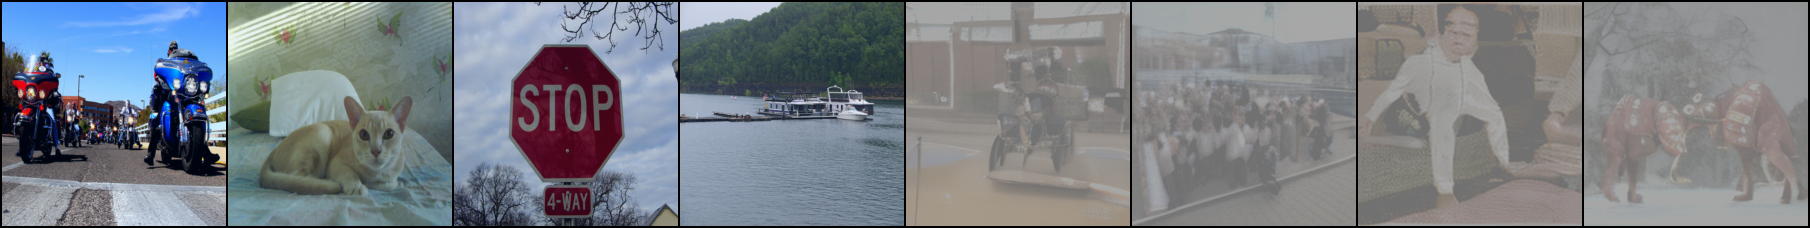

In [ ]:
generated_grid

## Continue

In [ ]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()

In [ ]:
ENCODER_PATH = '/content/drive/MyDrive/NeuroVision/contrastive_outputs_alljoined/run_20250913_201905/contrastive_eeg_encoder_best.pth'


In [ ]:
import os
import torch
import timm
from pathlib import Path
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
from torchvision.utils import make_grid

# ==============================================================================
# --- 1. CONFIGURATION for Projection GAN ---
# ==============================================================================
class CONFIG_PROJ_GAN:
    # --- UPDATE THIS PATH ---
    CONTRASTIVE_ENCODER_PATH = '/content/drive/MyDrive/NeuroVision/contrastive_outputs_alljoined/run_20250913_201905/contrastive_eeg_encoder_best.pth'

    # --- Source Data Path ---
    PROCESSED_DATA_ROOT = '/content/alljoined_final_224_split'

    # --- Output Paths ---
    OUTPUT_DIR = '/content/drive/MyDrive/NeuroVision/proj_gan_reconstructions'

    # --- Hyperparameters ---
    LR_G = 0.0002
    LR_D = 0.0002
    BETA1 = 0.5
    BETA2 = 0.999
    BATCH_SIZE = 64
    NUM_EPOCHS = 200

    # --- Model Dimensions & Settings ---
    IMG_SIZE = 128
    EEG_CHANNELS = 64
    EEG_ENCODER_DIM = 192
    GENERATOR_LATENT_DIM = 100

# ==============================================================================
# --- 2. DATASET CLASSES ---
# ==============================================================================
class GanImageDataset(Dataset):
    def __init__(self, cached_root_dir, image_transform):
        self.image_transform = image_transform
        self.samples = list(Path(cached_root_dir).glob('sample_*.pt'))

    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        data = torch.load(self.samples[idx])
        return self.image_transform(data['image_tensor'])

class EegPromptDataset(Dataset):
    def __init__(self, cached_root_dir, eeg_transform):
        self.eeg_transform = eeg_transform
        self.samples = list(Path(cached_root_dir).glob('sample_*.pt'))

    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        data = torch.load(self.samples[idx])
        return self.eeg_transform(data['spectrogram_tensor'])

# ==============================================================================
# --- 3. MODEL ARCHITECTURES (CORRECTED) ---
# ==============================================================================
class Generator(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.eeg_proj = nn.Linear(config.EEG_ENCODER_DIM, config.GENERATOR_LATENT_DIM)

        self.main = nn.Sequential(
            nn.ConvTranspose2d(config.GENERATOR_LATENT_DIM * 2, 1024, 4, 1, 0, bias=False),
            nn.BatchNorm2d(1024), nn.ReLU(True),
            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512), nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256), nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128), nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64), nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, eeg_features, noise):
        eeg_proj = self.eeg_proj(eeg_features)
        combined_input = torch.cat([noise, eeg_proj], dim=1)
        return self.main(combined_input.unsqueeze(-1).unsqueeze(-1))

class ProjectionDiscriminator(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.eeg_proj = nn.Linear(config.EEG_ENCODER_DIM, 512 * 4 * 4)

        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False), nn.BatchNorm2d(128), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False), nn.BatchNorm2d(256), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False), nn.BatchNorm2d(512), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 512, 4, 2, 1, bias=False), nn.BatchNorm2d(512), nn.LeakyReLU(0.2, inplace=True),
        )
        self.final_conv = nn.Conv2d(512, 1, 4, 1, 0, bias=False)

    def forward(self, image, eeg_features):
        image_features = self.main(image)
        real_fake_score = self.final_conv(image_features).view(-1, 1)

        eeg_proj = self.eeg_proj(eeg_features).view(-1, 512, 4, 4)
        consistency_score = torch.sum(image_features * eeg_proj, dim=[1, 2, 3]).view(-1, 1)

        return real_fake_score + consistency_score

# ==============================================================================
# --- 4. MAIN TRAINING SCRIPT ---
# ==============================================================================
def run_gan_training(config):
    # --- Setup ---
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    output_dir = os.path.join(config.OUTPUT_DIR, f'run_{timestamp}')
    samples_dir = os.path.join(output_dir, 'samples')
    model_dir = os.path.join(output_dir, 'model') # <-- Directory for saved models
    os.makedirs(samples_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # --- Load EEG Encoder ---
    eeg_encoder = timm.create_model('vit_tiny_patch16_224', pretrained=True, in_chans=config.EEG_CHANNELS, num_classes=0)
    eeg_encoder.load_state_dict(torch.load(config.CONTRASTIVE_ENCODER_PATH, map_location='cpu'))
    eeg_encoder.to(device).eval()

    # --- Prepare Data ---
    mean = torch.load(Path(config.PROCESSED_DATA_ROOT) / 'mean.pt')
    std = torch.load(Path(config.PROCESSED_DATA_ROOT) / 'std.pt')

    image_transform = transforms.Compose([
        transforms.Resize(config.IMG_SIZE),
        transforms.CenterCrop(config.IMG_SIZE),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    eeg_transform = transforms.Compose([transforms.Normalize(mean=mean.tolist(), std=std.tolist())])

    train_image_dataset = GanImageDataset(os.path.join(config.PROCESSED_DATA_ROOT, 'train'), image_transform)
    test_eeg_dataset = EegPromptDataset(os.path.join(config.PROCESSED_DATA_ROOT, 'test'), eeg_transform)

    train_loader = DataLoader(train_image_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True, persistent_workers=True)

    test_eeg_spectrograms = torch.stack([test_eeg_dataset[i] for i in range(min(64, len(test_eeg_dataset)))]).to(device)
    with torch.no_grad():
        fixed_eeg_prompts = eeg_encoder.forward_features(test_eeg_spectrograms)[:, 0]

    # --- Initialize Models, Optimizers, and Criterion ---
    generator = Generator(config).to(device)
    discriminator = ProjectionDiscriminator(config).to(device)
    optimizerD = optim.Adam(discriminator.parameters(), lr=config.LR_D, betas=(config.BETA1, config.BETA2))
    optimizerG = optim.Adam(generator.parameters(), lr=config.LR_G, betas=(config.BETA1, config.BETA2))
    criterion = nn.BCEWithLogitsLoss()

    best_loss_g = float('inf') # <-- Initialize best generator loss

    # --- Training Loop ---
    print("\n--- Starting Projection GAN Training ---")
    for epoch in range(config.NUM_EPOCHS):
        total_loss_g = 0.0 # <-- Accumulator for epoch's generator loss
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config.NUM_EPOCHS}")

        for real_images in progress_bar:
            real_images = real_images.to(device)
            b_size = real_images.size(0)

            # --- Train Discriminator ---
            discriminator.zero_grad()
            label_real = torch.full((b_size,), 1.0, device=device)
            label_fake = torch.full((b_size,), 0.0, device=device)

            random_indices = torch.randint(0, fixed_eeg_prompts.size(0), (b_size,))
            batch_eeg_prompts = fixed_eeg_prompts[random_indices]

            output_real = discriminator(real_images, batch_eeg_prompts.detach())
            errD_real = criterion(output_real.squeeze(), label_real)
            errD_real.backward()

            noise = torch.randn(b_size, config.GENERATOR_LATENT_DIM, device=device)
            fake_images = generator(batch_eeg_prompts, noise)
            output_fake = discriminator(fake_images.detach(), batch_eeg_prompts.detach())
            errD_fake = criterion(output_fake.squeeze(), label_fake)
            errD_fake.backward()
            optimizerD.step()
            errD = errD_real + errD_fake

            # --- Train Generator ---
            generator.zero_grad()
            output_G = discriminator(fake_images, batch_eeg_prompts)
            errG = criterion(output_G.squeeze(), label_real)
            errG.backward()
            optimizerG.step()

            total_loss_g += errG.item() # <-- Accumulate generator loss
            progress_bar.set_postfix(Loss_D=f"{errD.item():.4f}", Loss_G=f"{errG.item():.4f}")

        # --- Save Sample Images and Best Model ---
        with torch.no_grad():
            fixed_noise = torch.randn(64, config.GENERATOR_LATENT_DIM, device=device)
            fake_samples = generator(fixed_eeg_prompts, fixed_noise).detach().cpu()
        grid = make_grid(fake_samples, padding=2, normalize=True)
        transforms.ToPILImage()(grid).save(os.path.join(samples_dir, f"epoch_{epoch+1}.png"))

        # --- NEW: Save the model if the generator loss has improved ---
        avg_loss_g = total_loss_g / len(train_loader)
        if avg_loss_g < best_loss_g:
            best_loss_g = avg_loss_g
            print(f"New best generator loss ({best_loss_g:.4f}). Saving model to best_model.pth")
            torch.save({
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
            }, os.path.join(model_dir, 'best_model.pth'))

    print("--- Training Complete ---")

# ==============================================================================
# --- 5. EXECUTION ---
# ==============================================================================
if __name__ == '__main__':
    proj_gan_config = CONFIG_PROJ_GAN()
    run_gan_training(proj_gan_config)